# EDA and Dataset Prep for Object Detection

In [1]:
import numpy as np
import time
import sys
import os
import random
from skimage import io
import pandas as pd
from matplotlib import pyplot as plt
from shutil import copyfile

import cv2
import tensorflow as tf

import json
%matplotlib inline

In [2]:
json_path = '/data/calTech/CalTechCameraTrapsBboxes.json'

with open(json_path) as f:
    data = json.loads(f.read())

#### Import the image data

In [3]:
image_df = pd.DataFrame(data['images'])
path_map = {row['id']:row['file_name']  for idx, row in image_df[['id', 'file_name']].iterrows()}

In [4]:
cat_map = {cat['id']:cat['name'] for cat in data['categories']}

#### Import the bounding boxes

In [5]:
bbox_df = pd.DataFrame(data['annotations'])
bbox_df['class'] = bbox_df['category_id'].apply(lambda x: cat_map[x])
bbox_df['file_path'] = bbox_df['image_id'].apply(lambda x: path_map[x])
bbox_df['file_path'] = '/data/calTech/cct_images/' + bbox_df['file_path']
bbox_df = bbox_df.rename({'id':'bbox_id'}, axis=1)
box_coords_df = bbox_df['bbox'].apply(pd.Series)
box_coords_df.columns = ['XStart', 'YStart', 'XLen', 'YLen']
bbox_df = pd.concat([bbox_df, box_coords_df], axis=1)
bbox_df = bbox_df.merge(image_df, how='left', left_on='image_id', right_on='id')
bbox_df['XMax'] = (bbox_df['XStart'] + bbox_df['XLen']) / bbox_df['width']
bbox_df['XMin'] = bbox_df['XStart'] / bbox_df['width']
bbox_df['YMax'] = (bbox_df['YStart'] + bbox_df['YLen']) / bbox_df['height']
bbox_df['YMin'] = bbox_df['YStart'] / bbox_df['height']

#### Subset the number of categories that might be useful for our analysis

Remove any images that contain a label other than our specified classes

In [6]:
# Specify the classes we care about
subset_categories = [
    'coyote',
    'deer',
    'bobcat',
    'dog',
    'car',
    'fox',
    'squirrel',
    'raccoon',
    'skunk',
    'mountain_lion'
]

# Get a list of the images that contain labels outside our specified subset
non_subset_images = bbox_df[~bbox_df['class'].isin(subset_categories)]['image_id']
# Remove those images from the bounding box dataframe
bbox_df = bbox_df[~bbox_df['image_id'].isin(non_subset_images)].reset_index(drop=True)
# Remove those images from the image dataframe
image_df = image_df[~image_df['id'].isin(bbox_df['image_id'])]

In [7]:
class_list = bbox_df['class'].unique()
class_list.sort()
class_list

array(['bobcat', 'car', 'coyote', 'deer', 'dog', 'fox', 'mountain_lion',
       'raccoon', 'skunk', 'squirrel'], dtype=object)

In [8]:
print(len(bbox_df))
bbox_df['class'].value_counts()

36984


raccoon          8099
coyote           6628
deer             6442
bobcat           5196
dog              2941
squirrel         2695
car              2615
skunk            1225
fox              1098
mountain_lion      45
Name: class, dtype: int64

### Display images with bounding boxes

#### Pack of raccoons

In [9]:
print('Number of boxable images: {}'.format(len(image_df)) )
print('First image in the dataset')
img_name = '5921635b-23d2-11e8-a6a3-ec086b02610b'
img_path = bbox_df[bbox_df['image_id'] == img_name]['file_path'].unique()[0]
print('\t Image ID: {}'.format(img_name))
print('\t Image path: {}'.format(img_path))
print('')
print('Number of bounding boxes: {}'.format(len(bbox_df)))
print('The number of bounding boxes are larger than number of images.')
print('')
print('Number of classes: {}'.format(len(subset_categories)))
img = io.imread(img_path)

Number of boxable images: 28014
First image in the dataset
	 Image ID: 5921635b-23d2-11e8-a6a3-ec086b02610b
	 Image path: /data/calTech/cct_images/5921635b-23d2-11e8-a6a3-ec086b02610b.jpg

Number of bounding boxes: 36984
The number of bounding boxes are larger than number of images.

Number of classes: 10


(1494, 2048, 3)


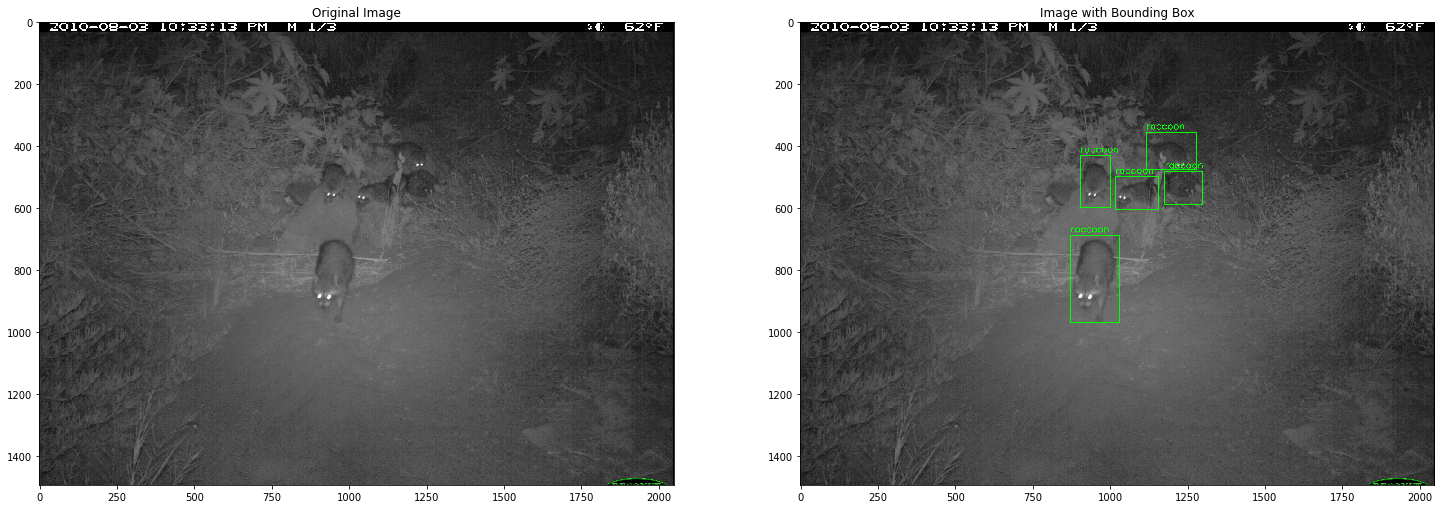

In [10]:
height, width, _ = img.shape
print(img.shape)
plt.figure(figsize=(25,20))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img)
bboxs = bbox_df[bbox_df['image_id']==img_name]
img_bbox = img.copy()
for index, row in bboxs.iterrows():
    xmin = int(row['XMin']*width)
    xmax = int(row['XMax']*width)
    ymin = int(row['YMin']*height)
    ymax = int(row['YMax']*height)
    label_name = row['class']
    cv2.rectangle(img_bbox,(xmin,ymin),(xmax,ymax),(0,255,0),2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_bbox,label_name,(xmin,ymin-10), font, 1,(0,255,0),2)
plt.subplot(1,2,2)
plt.title('Image with Bounding Box')
plt.imshow(img_bbox)
plt.show()

#### Bobcat eating a squirrel

In [11]:
print('Number of boxable images: {}'.format(len(image_df)) )
print('First image in the dataset')
img_name = '599d7e8c-23d2-11e8-a6a3-ec086b02610b'
img_path = bbox_df[bbox_df['image_id'] == img_name]['file_path'].unique()[0]
print('\t Image ID: {}'.format(img_name))
print('\t Image path: {}'.format(img_path))
print('')
print('Number of bounding boxes: {}'.format(len(bbox_df)))
print('The number of bounding boxes are larger than number of images.')
print('')
print('Number of classes: {}'.format(len(subset_categories)))
img = io.imread(img_path)

Number of boxable images: 28014
First image in the dataset
	 Image ID: 599d7e8c-23d2-11e8-a6a3-ec086b02610b
	 Image path: /data/calTech/cct_images/599d7e8c-23d2-11e8-a6a3-ec086b02610b.jpg

Number of bounding boxes: 36984
The number of bounding boxes are larger than number of images.

Number of classes: 10


(1494, 2048, 3)


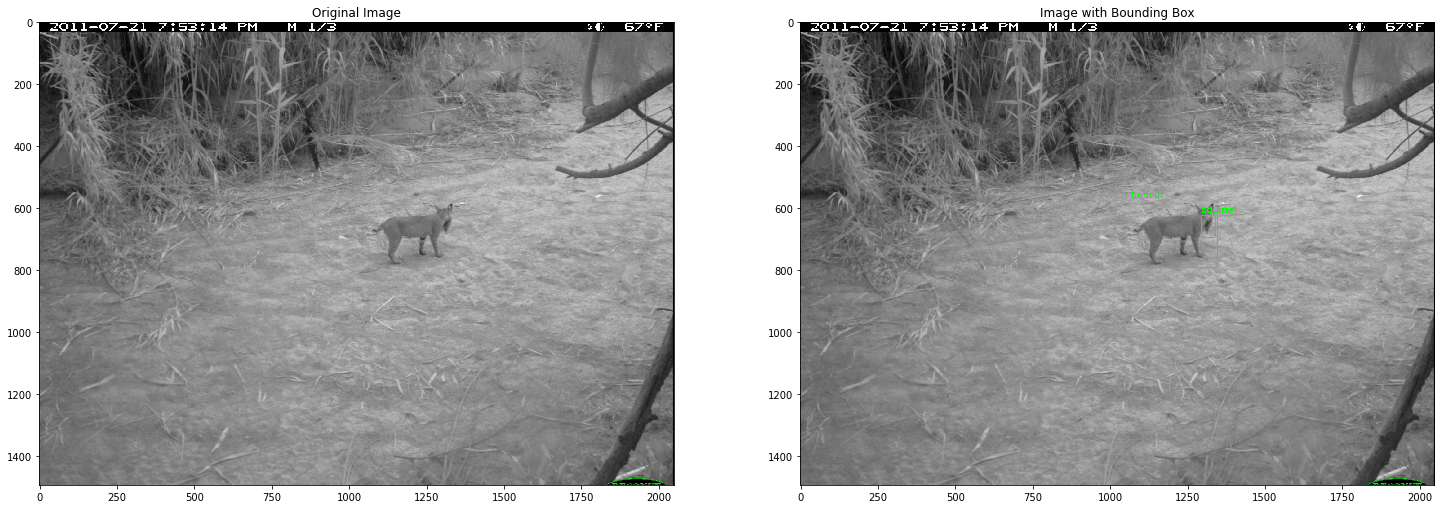

In [12]:
height, width, _ = img.shape
print(img.shape)
plt.figure(figsize=(25,20))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img)
bboxs = bbox_df[bbox_df['image_id']==img_name]
img_bbox = img.copy()
for index, row in bboxs.iterrows():
    xmin = int(row['XMin']*width)
    xmax = int(row['XMax']*width)
    ymin = int(row['YMin']*height)
    ymax = int(row['YMax']*height)
    label_name = row['class']
    cv2.rectangle(img_bbox,(xmin,ymin),(xmax,ymax),(0,255,0),2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_bbox,label_name,(xmin,ymin-10), font, 1,(0,255,0),2)
plt.subplot(1,2,2)
plt.title('Image with Bounding Box')
plt.imshow(img_bbox)
plt.show()

#### Mountain Lion

In [13]:
print('Number of boxable images: {}'.format(len(image_df)) )
print('First image in the dataset')
img_name = '5a2c8447-23d2-11e8-a6a3-ec086b02610b'
img_path = bbox_df[bbox_df['image_id'] == img_name]['file_path'].unique()[0]
print('\t Image ID: {}'.format(img_name))
print('\t Image path: {}'.format(img_path))
print('')
print('Number of bounding boxes: {}'.format(len(bbox_df)))
print('The number of bounding boxes are larger than number of images.')
print('')
print('Number of classes: {}'.format(len(subset_categories)))
img = io.imread(img_path)

Number of boxable images: 28014
First image in the dataset
	 Image ID: 5a2c8447-23d2-11e8-a6a3-ec086b02610b
	 Image path: /data/calTech/cct_images/5a2c8447-23d2-11e8-a6a3-ec086b02610b.jpg

Number of bounding boxes: 36984
The number of bounding boxes are larger than number of images.

Number of classes: 10


(1494, 2048, 3)


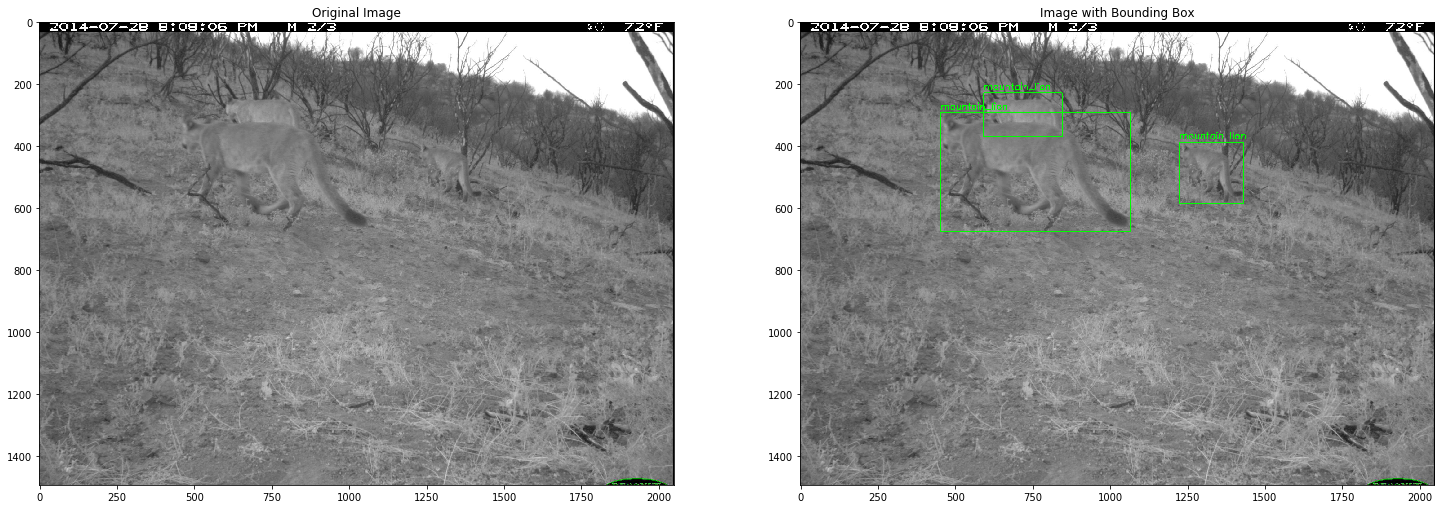

In [14]:
height, width, _ = img.shape
print(img.shape)
plt.figure(figsize=(25,20))
plt.subplot(1,2,1)
plt.title('Original Image')
plt.imshow(img)
bboxs = bbox_df[bbox_df['image_id']==img_name]
img_bbox = img.copy()
for index, row in bboxs.iterrows():
    xmin = int(row['XMin']*width)
    xmax = int(row['XMax']*width)
    ymin = int(row['YMin']*height)
    ymax = int(row['YMax']*height)
    label_name = row['class']
    cv2.rectangle(img_bbox,(xmin,ymin),(xmax,ymax),(0,255,0),2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_bbox,label_name,(xmin,ymin-10), font, 1,(0,255,0),2)
plt.subplot(1,2,2)
plt.title('Image with Bounding Box')
plt.imshow(img_bbox)
plt.show()

## EDA

In [15]:
bbox_df.dtypes

bbox               object
category_id         int64
bbox_id            object
image_id           object
class              object
file_path          object
XStart            float64
YStart            float64
XLen              float64
YLen              float64
date_captured      object
file_name          object
frame_num           int64
height              int64
id                 object
location            int64
rights_holder      object
seq_id             object
seq_num_frames      int64
width               int64
XMax              float64
XMin              float64
YMax              float64
YMin              float64
dtype: object

In [16]:
print('Bounding box count: {}'.format(len(bbox_df)))
print('Image count: {}'.format(bbox_df['image_id'].nunique()))
print('Class count: {}'.format(bbox_df['class'].nunique()))
print('Location count: {}'.format(bbox_df['location'].nunique()))
print('Image seq count: {}'.format(bbox_df['seq_id'].nunique()))

Bounding box count: 36984
Image count: 35088
Class count: 10
Location count: 82
Image seq count: 17447


In [17]:
bbox_df.sort_values(['date_captured', 'seq_id', 'frame_num'])[['date_captured', 'location', 'frame_num', 'class', 'image_id', 'bbox_id']].head(15)

,date_captured,location,frame_num,class,image_id,bbox_id
18753,11 11,56,1,fox,5a2c86ab-23d2-11e8-a6a3-ec086b02610b,2b80f606-cbf1-11e8-819c-970a9450cdbc
17067,2010-05-26 11:48:19,100,1,squirrel,59247b5d-23d2-11e8-a6a3-ec086b02610b,2b647396-cbf1-11e8-819c-970a9450cdbc
2414,2010-05-26 11:48:20,100,2,squirrel,586fdcfb-23d2-11e8-a6a3-ec086b02610b,2a7943d0-cbf1-11e8-819c-970a9450cdbc
14905,2010-05-26 11:48:21,100,3,squirrel,58adc2eb-23d2-11e8-a6a3-ec086b02610b,2b40ea2a-cbf1-11e8-819c-970a9450cdbc
3792,2010-05-26 11:48:22,100,4,squirrel,587d3fa7-23d2-11e8-a6a3-ec086b02610b,2a8fb07a-cbf1-11e8-819c-970a9450cdbc
10540,2010-05-26 11:48:23,100,5,squirrel,58e7253e-23d2-11e8-a6a3-ec086b02610b,2af9313a-cbf1-11e8-819c-970a9450cdbc
12696,2010-05-27 03:53:21,100,1,raccoon,5935a916-23d2-11e8-a6a3-ec086b02610b,2b1c359a-cbf1-11e8-819c-970a9450cdbc
27780,2010-05-27 03:53:22,100,2,raccoon,58718556-23d2-11e8-a6a3-ec086b02610b,2c0d9d18-cbf1-11e8-819c-970a9450cdbc
18835,2010-05-27 03:53:23,100,3,raccoon,592c4bcb-23d2-11e8-a6a3-ec086b02610b,2b821270-cbf1-11e8-819c-970a9450cdbc
4866,2010-05-27 03:53:24,100,4,raccoon,58a52e99-23d2-11e8-a6a3-ec086b02610b,2a9ff08e-cbf1-11e8-819c-970a9450cdbc


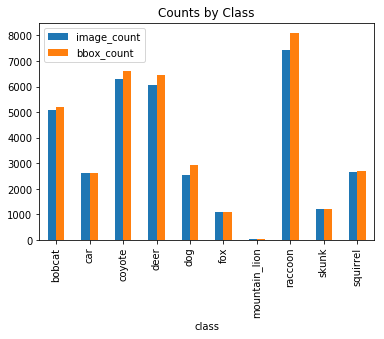

In [18]:
# Get image and bounding box count by species
count_df = bbox_df.groupby('class').agg({'file_path':[pd.Series.nunique, 'count']})
count_df.columns = ['image_count', 'bbox_count']
count_df.plot.bar()
plt.title('Counts by Class')
plt.show()

Counts of Bounding Boxes by location


count      82.000000
mean      451.024390
std       681.497044
min         6.000000
25%        50.000000
50%       178.000000
75%       509.500000
max      3299.000000
Name: bbox_id, dtype: float64

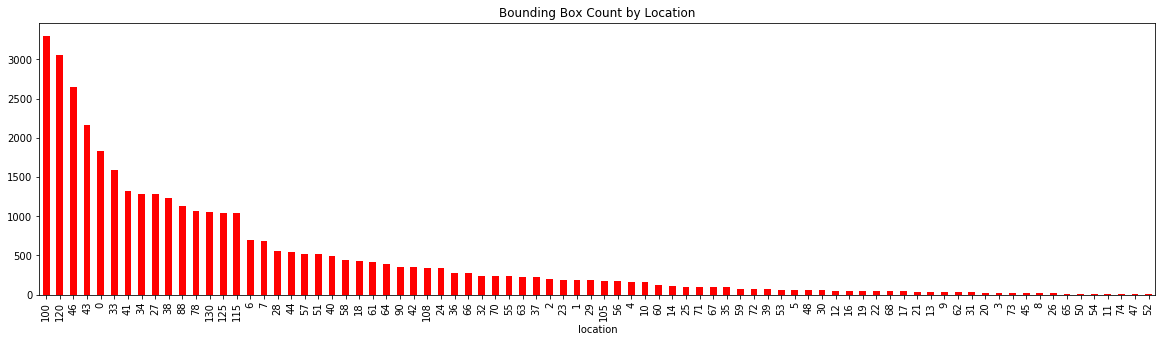

In [21]:
# Plot the bbox count by location
print('Counts of Bounding Boxes by location')
bbox_counts = bbox_df.groupby(['location'])['bbox_id'].nunique()
display(bbox_counts.describe())
bbox_counts.sort_values(ascending=False).plot.bar(figsize=(20,5), color='red')
plt.title("Bounding Box Count by Location")
plt.show()

Counts of Images by location


count      82.000000
mean      427.902439
std       651.977800
min         6.000000
25%        50.000000
50%       166.000000
75%       459.500000
max      3043.000000
Name: image_id, dtype: float64

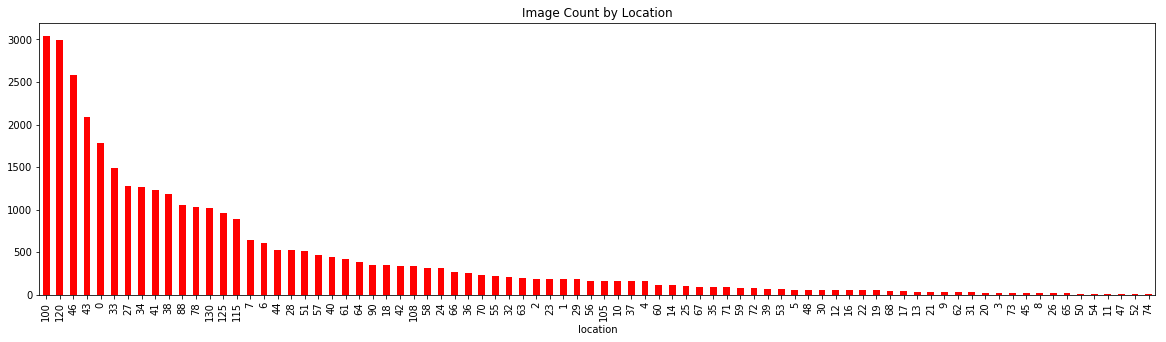

In [22]:
# Plot the image count by location
print('Counts of Images by location')
image_counts = bbox_df.groupby(['location'])['image_id'].nunique()
display(image_counts.describe())
image_counts.sort_values(ascending=False).plot.bar(figsize=(20,5), color='red')
plt.title("Image Count by Location")
plt.show()

Counts of classes by location


count    82.000000
mean      4.134146
std       1.690658
min       1.000000
25%       3.000000
50%       4.000000
75%       5.000000
max       9.000000
Name: class, dtype: float64

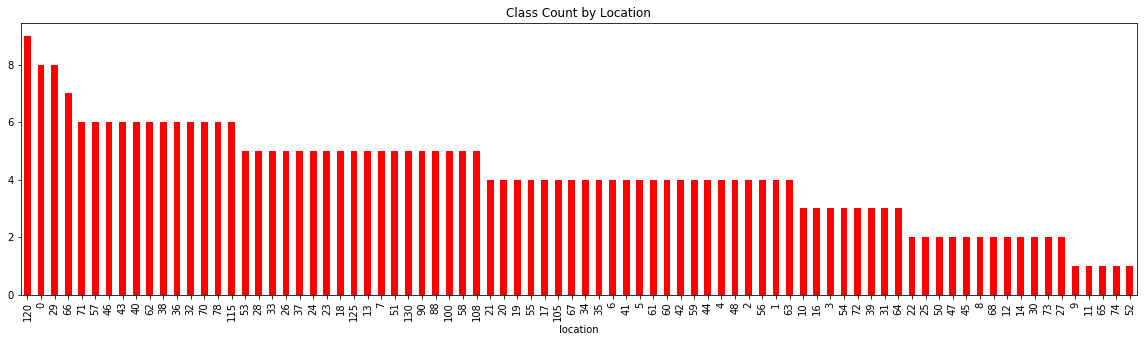

In [23]:
# Plot the image count by location
print('Counts of classes by location')
class_counts = bbox_df.groupby(['location'])['class'].nunique()
display(class_counts.describe())
class_counts.sort_values(ascending=False).plot.bar(figsize=(20,5), color='red')
plt.title("Class Count by Location")
plt.show()

In [24]:
bbox_df.head()

,bbox,category_id,bbox_id,image_id,class,file_path,XStart,YStart,XLen,YLen,...,id,location,rights_holder,seq_id,seq_num_frames,width,XMax,XMin,YMax,YMin
0,"[1779.2, 407.04, 61.440000000000055, 84.480000...",5,2a54599e-cbf1-11e8-819c-970a9450cdbc,593d68d7-23d2-11e8-a6a3-ec086b02610b,squirrel,/data/calTech/cct_images/593d68d7-23d2-11e8-a6...,1779.200000,407.040000,61.440000,84.480000,...,593d68d7-23d2-11e8-a6a3-ec086b02610b,90,Justin Brown,6f0f6778-5567-11e8-b5d2-dca9047ef277,3,2048,0.898750,0.868750,0.328996,0.272450
1,"[540.16, 1013.76, 394.24, 480.0]",3,2a546254-cbf1-11e8-819c-970a9450cdbc,588a66f6-23d2-11e8-a6a3-ec086b02610b,raccoon,/data/calTech/cct_images/588a66f6-23d2-11e8-a6...,540.160000,1013.760000,394.240000,480.000000,...,588a66f6-23d2-11e8-a6a3-ec086b02610b,100,Justin Brown,6f1d18f8-5567-11e8-a669-dca9047ef277,5,2048,0.456250,0.263750,0.999839,0.678554
2,"[1340.0574803351963, 633.435833454134, 605.675...",34,2a54634e-cbf1-11e8-819c-970a9450cdbc,59adfdd1-23d2-11e8-a6a3-ec086b02610b,deer,/data/calTech/cct_images/59adfdd1-23d2-11e8-a6...,1340.057480,633.435833,605.675697,560.250020,...,59adfdd1-23d2-11e8-a6a3-ec086b02610b,27,Justin Brown,70126345-5567-11e8-a287-dca9047ef277,3,2048,0.950065,0.654325,0.798987,0.423987
3,"[427.52, 128.0, 1620.48, 1359.3600000000001]",9,2a546448-cbf1-11e8-819c-970a9450cdbc,59bac8fe-23d2-11e8-a6a3-ec086b02610b,coyote,/data/calTech/cct_images/59bac8fe-23d2-11e8-a6...,427.520000,128.000000,1620.480000,1359.360000,...,59bac8fe-23d2-11e8-a6a3-ec086b02610b,61,Justin Brown,701361b0-5567-11e8-959e-dca9047ef277,3,2048,1.000000,0.208750,0.995556,0.085676
4,"[692.6979910714285, 1041.92, 477.2220089285715...",3,2a546790-cbf1-11e8-819c-970a9450cdbc,58b4a905-23d2-11e8-a6a3-ec086b02610b,raccoon,/data/calTech/cct_images/58b4a905-23d2-11e8-a6...,692.697991,1041.920000,477.222009,380.936786,...,58b4a905-23d2-11e8-a6a3-ec086b02610b,125,Justin Brown,6f162b6b-5567-11e8-b56b-dca9047ef277,3,2048,0.571250,0.338231,0.952381,0.697403


## Prep dataset for training

- Remove locations with only one species
- Remove locations with fewer than 20 photos
- Split into train/test partitioned by location
- Ensure that split contains at least some mountain lions in train and test

In [25]:
loc_df = bbox_df.groupby('location').agg({'class':pd.Series.nunique, 'image_id':pd.Series.nunique}).reset_index(drop=False)
loc_df.columns = ['location', 'class_count', 'image_count']
loc_df = loc_df[(loc_df['class_count'] >= 2) & (loc_df['image_count'] >= 20)]

In [26]:
bbox_sub_df = bbox_df[bbox_df['location'].isin(loc_df['location'])]

In [27]:
print('Bounding box count: {}'.format(len(bbox_sub_df)))
print('Image count: {}'.format(bbox_sub_df['image_id'].nunique()))
print('Class count: {}'.format(bbox_sub_df['class'].nunique()))
print('Location count: {}'.format(bbox_sub_df['location'].nunique()))
print('Image seq count: {}'.format(bbox_sub_df['seq_id'].nunique()))

Bounding box count: 36831
Image count: 34935
Class count: 10
Location count: 71
Image seq count: 17370


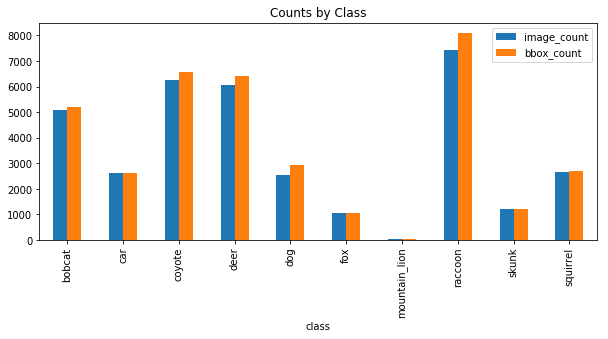

,image_count,bbox_count
class,,
bobcat,5069,5195
car,2615,2615
coyote,6256,6566
deer,6048,6421
dog,2561,2941
fox,1047,1054
mountain_lion,33,45
raccoon,7437,8099
skunk,1203,1209


In [25]:
# Get image and bounding box count by species
count_df = bbox_sub_df.groupby('class').agg({'file_path':[pd.Series.nunique, 'count']})
count_df.columns = ['image_count', 'bbox_count']

count_df.plot.bar(figsize=(10,4))
plt.title('Counts by Class')
plt.show()
display(count_df)

### Split into training and test

It's hard to find a split that doesn't remove a class from either training or test or risk biasing the results. From here on out, take any results from *car* and *mountain_lion* with a grain of salt as they are heavily loaded on only a few locations or have very few observations.

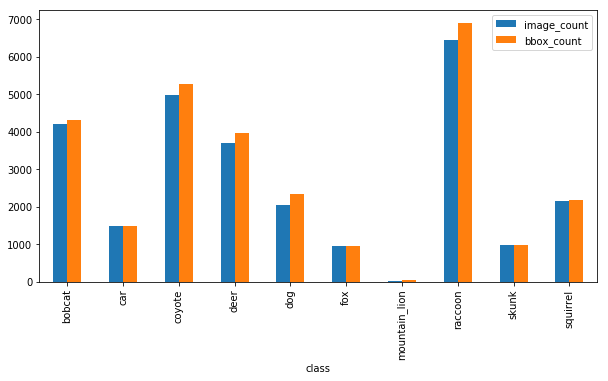

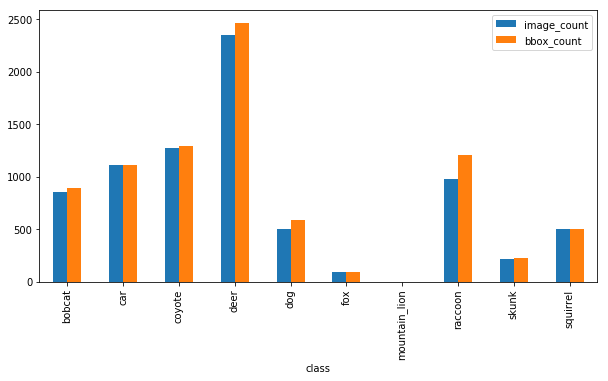

In [28]:
from sklearn.model_selection import train_test_split

# Split the filtered locations into training and test
train_locs, test_locs = train_test_split(bbox_sub_df['location'].unique(), random_state=7)


# Build a training and test set based on the locations
train_df = bbox_sub_df[bbox_sub_df['location'].isin(train_locs)]
test_df = bbox_sub_df[bbox_sub_df['location'].isin(test_locs)]

# Plot the class distributions after the split
train_count_df = train_df.groupby('class').agg({'file_path':[pd.Series.nunique, 'count']})
train_count_df.columns = ['image_count', 'bbox_count']
train_count_df.plot.bar(figsize=(10,5))
plt.show()

test_count_df = test_df.groupby('class').agg({'file_path':[pd.Series.nunique, 'count']})
test_count_df.columns = ['image_count', 'bbox_count']
test_count_df.plot.bar(figsize=(10,5))
plt.show()

### Write out the training and test sets

In [30]:
# output_dir = '/data/TensorFlow/workspace/object_detection/'
output_dir = '/data/tlt/workspace/'

train_df.to_csv(os.path.join(output_dir, 'train_annotations.csv'), index=False)
test_df.to_csv(os.path.join(output_dir, 'test_annotations.csv'), index=False)

#### Write out the training annotations data

#### Write out the test annotations data

### Copy images over to train and test folders

In [32]:
calTech_img_folder = '/data/calTech/cct_images/'

Copy files into training folder

In [34]:
img_folder = '/data/tlt/workspace/data/JPEGImages/'
img_set = 'train_'

for idx, row in train_df.iterrows():
    old_path = os.path.join(calTech_img_folder, row['file_name'])
    new_path = os.path.join(img_folder, img_set + row['file_name'])
    copyfile(old_path, new_path)

In [35]:
img_folder = '/data/tlt/workspace/data/JPEGImages/'
img_set = 'test_'

for idx, row in test_df.iterrows():
    old_path = os.path.join(calTech_img_folder, row['file_name'])
    new_path = os.path.join(img_folder, img_set + row['file_name'])
    copyfile(old_path, new_path)

### Convert train and test to xml .annotation files

In [37]:
def write_bbox_xml(label, xmin, xmax, ymin, ymax):
    
    bbox_str = """
    <object>
        <name>{label}</name>
        <bndbox>
            <xmin>{xmin}</xmin>
            <ymin>{ymin}</ymin>
            <xmax>{xmax}</xmax>
            <ymax>{ymax}</ymax>
        </bndbox>
    </object>"""
    bbox_str = bbox_str.format(label=label, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
    
    return bbox_str

def img_to_xml(data, folder):
    parent_folder = os.path.basename(os.path.normpath(folder))
    filename = data['file_name'].iloc[0]
    path = os.path.join(folder, filename)
    width = data['width'].iloc[0]
    height = data['height'].iloc[0]

    annotation_str = """
<annotation>
    <folder>{folder}</folder>
    <filename>{filename}</filename>
    <path>{path}</path>
    <source>
        <database>calTech</database>
    </source>
    <size>
        <width>{width}</width>
        <height>{height}</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>"""
    annotation_str = annotation_str.format(folder=parent_folder, 
                                           filename=filename, 
                                           path=path, 
                                           width=width, 
                                           height=height)
    
    for idx, row in data.iterrows():
        label = row['class']
        xmin = int(row['XMin']*width)
        xmax = int(row['XMax']*width)
        ymin = int(row['YMin']*height)
        ymax = int(row['YMax']*height)
        bbox_str = write_bbox_xml(label, xmin, xmax, ymin, ymax)
        annotation_str += bbox_str
        
    annotation_str += "\n</annotation>"
    
    return annotation_str

def dataframe_to_xml(data, folder, output_dir, train_test):
    for key, grp in data.groupby('image_id'):
        xml_file = os.path.join(output_dir, train_test + key + '.xml')
        xml_str = img_to_xml(grp, folder)
        with open(xml_file, 'w') as f:
            f.write(xml_str)
        

Create xml files for both train and test

In [38]:
annotations_folder = '/data/tlt/workspace/data/Annotations/'
img_set = 'train_'

dataframe_to_xml(train_df, annotations_folder, annotations_folder, img_set)

In [39]:
annotations_folder = '/data/tlt/workspace/data/Annotations/'
img_set = 'test_'

dataframe_to_xml(test_df, annotations_folder, annotations_folder, img_set)

In [127]:
test_folder = '/data/TensorFlow/workspace/object_detection/images/test/'

dataframe_to_xml(test_df, test_folder, test_folder)